In [1]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
tensorflow 2.0.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.3 which is incompatible.
awscli 1.18.20 has requirement botocore==1.15.20, but you'll have botocore 1.15.23 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
tensorflow 2.0.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.3 which is incompatible.
awscli 1.18.20 has requirement botocore==1.15.20, but you'll have botocore 1.15.23 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading v

In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download Dataset

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

For reference, here is the schema:



# Amazon Customer Reviews Dataset

### Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.



In [3]:
!aws s3 cp 's3://{bucket}/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [4]:
import csv

df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE,
                 compression='gzip')
df.shape

(102084, 15)

In [5]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Clean commas from raw text
_Note:  This is not needed as the data does not currently contain commas._

In [6]:
df_scrubbed_raw = df

# df_scrubbed_raw['marketplace'] = df_scrubbed_raw['marketplace'].replace(',', ' ')
# df_scrubbed_raw['review_id'] = df_scrubbed_raw['review_id'].replace(',', ' ')
# df_scrubbed_raw['product_id'] = df_scrubbed_raw['product_id'].replace(',', ' ')
# df_scrubbed_raw['product_title'] = df_scrubbed_raw['product_title'].replace(',', ' ')
# df_scrubbed_raw['product_category'] = df_scrubbed_raw['product_category'].replace(',', ' ')
# df_scrubbed_raw['review_headline'] = df_scrubbed_raw['review_headline'].replace(',', ' ')
# df_scrubbed_raw['review_body'] = df_scrubbed_raw['review_body'].replace(',', ' ')
# df_scrubbed_raw['review_date'] = df_scrubbed_raw['review_date'].replace(',', ' ')

df_scrubbed_raw.shape

(102084, 15)

In [7]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Drop NaNs

In [8]:
df_scrubbed_raw.isna().values.any()

False

In [9]:
df_scrubbed_raw = df_scrubbed_raw.dropna()
df_scrubbed_raw = df_scrubbed_raw.reset_index(drop=True)
df_scrubbed_raw.shape

(102084, 15)

In [10]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


### Enrich the data with `is_positive_sentiment` label
* True:  `star_rating >= 4`
* False:  `star_rating < 4`

In [11]:
df_is_positive_sentiment = (df_scrubbed_raw['star_rating'] >= 4).astype(int)
df_scrubbed_raw.insert(0, 'is_positive_sentiment', df_is_positive_sentiment)
df_scrubbed_raw.shape

(102084, 16)

In [12]:
df_scrubbed_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,1,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,0,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,0,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,1,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,1,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Split the data into `train` and `test` datasets

In [13]:
from sklearn.model_selection import train_test_split

df_unbalanced_raw = df_scrubbed_raw

print('df_unbalanced_raw.shape={}'.format(df_unbalanced_raw.shape))

# Split all data into 90% train and 10% test
df_unbalanced_raw_train, df_unbalanced_raw_test = train_test_split(df_unbalanced_raw, test_size=0.1, stratify=df_scrubbed_raw['is_positive_sentiment'])

df_unbalanced_raw_train = df_unbalanced_raw_train.reset_index(drop=True)
df_unbalanced_raw_test = df_unbalanced_raw_test.reset_index(drop=True)

print('df_unbalanced_raw_train.shape={}'.format(df_unbalanced_raw_train.shape))
print('df_unbalanced_raw_test.shape={}'.format(df_unbalanced_raw_test.shape))

df_unbalanced_raw.shape=(102084, 16)
df_unbalanced_raw_train.shape=(91875, 16)
df_unbalanced_raw_test.shape=(10209, 16)


## Write the data files locally

In [14]:
prefix_unbalanced_raw_train = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv'
prefix_unbalanced_raw_test = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv'

unbalanced_raw_with_header_train_path = './{}/data.csv'.format(prefix_unbalanced_raw_train)
unbalanced_raw_with_header_test_path = './{}/data.csv'.format(prefix_unbalanced_raw_test)

import os
os.makedirs(prefix_unbalanced_raw_train, exist_ok=True)
os.makedirs(prefix_unbalanced_raw_test, exist_ok=True)

# Only review_body
df_unbalanced_raw_train[['is_positive_sentiment', 'review_body']].to_csv(unbalanced_raw_with_header_train_path, index=False, header=True)
df_unbalanced_raw_test[['is_positive_sentiment', 'review_body']].to_csv(unbalanced_raw_with_header_test_path, index=False, header=True)

# All features
# df_unbalanced_raw_train.to_csv(unbalanced_raw_with_header_train_path, index=False, header=True)
# df_unbalanced_raw_test.to_csv(unbalanced_raw_with_header_test_path, index=False, header=True)


In [15]:
unbalanced_raw_with_header_train_s3_uri = sess.upload_data(path=unbalanced_raw_with_header_train_path, key_prefix=prefix_unbalanced_raw_train)
unbalanced_raw_with_header_test_s3_uri = sess.upload_data(path=unbalanced_raw_with_header_test_path, key_prefix=prefix_unbalanced_raw_test)

print(unbalanced_raw_with_header_train_s3_uri)
print(unbalanced_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv/data.csv


In [16]:
!aws s3 ls $unbalanced_raw_with_header_train_s3_uri
!aws s3 ls $unbalanced_raw_with_header_test_s3_uri

2020-03-18 20:47:28   34799814 data.csv
2020-03-18 20:47:28    3805771 data.csv


In [17]:
!aws s3 ls --recursive 's3://{bucket}/feature-store/amazon-reviews-autopilot'

2020-03-18 20:15:38    3140440 feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv/data.csv
2020-03-18 20:14:21   28533433 feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv/data.csv
2020-03-18 20:47:28    3805771 feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv/data.csv
2020-03-18 20:47:28   34799814 feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv/data.csv


# View the Class Imbalance (Train)

### Note:  You may need to run this next cell twice


In [20]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_unbalanced_raw_train)


In [21]:
is_positive_sentiment_count_unbalanced_raw_train = len(df_unbalanced_raw_train.query('is_positive_sentiment == 1'))
is_negative_sentiment_count_unbalanced_raw_train = len(df_unbalanced_raw_train.query('is_positive_sentiment == 0'))

print('Majority (positive) count: {}'.format(is_positive_sentiment_count_unbalanced_raw_train))
print('Minority (negative) count: {}'.format(is_negative_sentiment_count_unbalanced_raw_train))
print('Ratio of Majority to Minority: {}'.format(is_positive_sentiment_count_unbalanced_raw_train / is_negative_sentiment_count_unbalanced_raw_train))

Majority (positive) count: 56792
Minority (negative) count: 35083
Ratio of Majority to Minority: 1.618789727218311


# Balance the Classes (Train-Split Only)

In [22]:
from sklearn.utils import resample

is_negative_sentiment_unbalanced_raw_train_df = df_unbalanced_raw_train.query('is_positive_sentiment == 0')
is_positive_sentiment_unbalanced_raw_train_df = df_unbalanced_raw_train.query('is_positive_sentiment == 1')

# TODO:  Check which sentiment has the least number of samples
#        We know we have more positive than negative sentiment samples in our case.

is_positive_downsampled_raw_train_df = resample(is_positive_sentiment_unbalanced_raw_train_df,
                                                replace = False,
                                                n_samples = len(is_negative_sentiment_unbalanced_raw_train_df))

df_balanced_train_raw = pd.concat([is_negative_sentiment_unbalanced_raw_train_df, is_positive_downsampled_raw_train_df])
df_balanced_train_raw = df_balanced_train_raw.reset_index(drop=True)

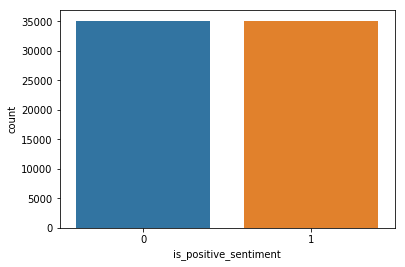

In [23]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_train_raw)


## Write the data files locally (Balanced, Train)


In [24]:
prefix_balanced_raw_train = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv'

balanced_raw_with_header_train_path = './{}/data.csv'.format(prefix_balanced_raw_train)

import os
os.makedirs(prefix_balanced_raw_train, exist_ok=True)

# Only review_body
df_balanced_train_raw[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_train_path, index=False, header=True)

# All features
#df_balanced_train_raw.to_csv(balanced_raw_with_header_train_path, index=False, header=True)


## Upload Only S3 (Balanced, Train)
We will use the test set later to verify.

In [25]:
balanced_raw_with_header_train_s3_uri = sess.upload_data(path=balanced_raw_with_header_train_path, key_prefix=prefix_balanced_raw_train)

print(balanced_raw_with_header_train_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv/data.csv


In [26]:
!aws s3 ls $balanced_raw_with_header_train_s3_uri


2020-03-18 20:14:21   28533433 data.csv


# Balance the Classes (Test-Split Only)

In [27]:
from sklearn.utils import resample

is_negative_sentiment_unbalanced_raw_test_df = df_unbalanced_raw_test.query('is_positive_sentiment == 0')
is_positive_sentiment_unbalanced_raw_test_df = df_unbalanced_raw_test.query('is_positive_sentiment == 1')

# TODO:  Check which sentiment has the least number of samples
#        We know we have more positive than negative sentiment samples in our case.

is_positive_downsampled_raw_test_df = resample(is_positive_sentiment_unbalanced_raw_test_df,
                                                replace = False,
                                                n_samples = len(is_negative_sentiment_unbalanced_raw_test_df))

df_balanced_test_raw = pd.concat([is_negative_sentiment_unbalanced_raw_test_df, is_positive_downsampled_raw_test_df])
df_balanced_test_raw = df_balanced_test_raw.reset_index(drop=True)

In [28]:
df_balanced_test_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,44125301,R2H4HYXMYZ31BG,B006IYOKYE,940379051,Learn Russian - Level 1: Introduction Audio Co...,Digital_Software,1,2,2,N,Y,Not helpful,Has some basic information on Russia but littl...,2012-07-20
1,0,US,13267885,RIEII6CFL6ED4,B00NG7K2RA,349370473,TurboTax Premier Fed + Efile + State,Digital_Software,2,0,0,N,Y,Two Stars,Not like previous years. I think next year we ...,2015-04-05
2,0,US,41045180,R2AKLD1N6PDXKD,B00PG8FWS6,292852441,Block Financial H&R Block Tax Software 14 Prem...,Digital_Software,1,0,2,N,Y,One Star,Blows chunks,2015-06-01
3,0,US,26255804,RL0KBXOOGAB53,B0068TJ7OC,740565112,H&R Block At Home 2011 Deluxe + State,Digital_Software,2,0,0,N,Y,will not use again,To use it was easy enough the thing that got m...,2012-04-12
4,0,US,38453850,R5Z3CI4QVYKYZ,B00R6DMM82,964800861,Creativity Collection: Memories and Milestones...,Digital_Software,1,1,1,N,Y,Waste,Very disappointing & inadequate.,2015-02-24


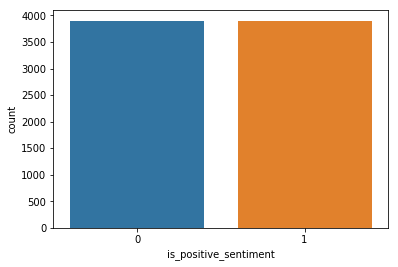

In [29]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_test_raw)


## Write the data files locally (Balanced, Test)


In [33]:
prefix_balanced_test_raw = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv'
balanced_raw_with_header_test_path = './{}/data.csv'.format(prefix_balanced_test_raw)

import os
os.makedirs(prefix_balanced_test_raw, exist_ok=True)

# Only review_body
df_balanced_test_raw[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_test_path, index=False, header=True)

# All
#df_balanced_test_raw.to_csv(balanced_raw_with_header_test_path, index=False, header=True)


## Upload to S3 (Balanced, Test)
We will use the test set later to verify.

In [35]:
balanced_raw_with_header_test_s3_uri = sess.upload_data(path=balanced_raw_with_header_test_path, key_prefix=prefix_balanced_test_raw)

print(balanced_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv/data.csv


In [36]:
!aws s3 ls $balanced_raw_with_header_test_s3_uri


2020-03-18 20:15:38    3140440 data.csv


In [39]:
!aws s3 ls --recursive 's3://{bucket}/feature-store/amazon-reviews-autopilot'

2020-03-18 20:15:38    3140440 feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv/data.csv
2020-03-18 20:14:21   28533433 feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv/data.csv
2020-03-18 20:14:13    3855031 feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv/data.csv
2020-03-18 20:14:12   34750554 feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv/data.csv


In [37]:
#!ls -R ./feature-store

./feature-store:
amazon-reviews-autopilot

./feature-store/amazon-reviews-autopilot:
raw-labeled-split-balanced-header-test-csv
raw-labeled-split-balanced-header-train-csv
raw-labeled-split-unbalanced-header-test-csv
raw-labeled-split-unbalanced-header-train-csv

./feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv:
data.csv

./feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv:
data.csv

./feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv:
data.csv

./feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv:
data.csv
